In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c
import v_x_interp as vx
# Set path for reading WARGSim dumps
path = "/home/keenan/Dumps/"

In [11]:
nDumps = 100
nParts = int(1e6)
dz     = 0.0005709391949757351;
z      = np.linspace(0, nDumps * dz, nDumps) * 1e6
x      = np.zeros((nDumps, nParts))
y      = np.zeros((nDumps, nParts))
xp     = np.zeros((nDumps, nParts))
yp     = np.zeros((nDumps, nParts))
gb     = np.zeros((nDumps, nParts))
t      = z / c;
t[0]   = 0;
tau    = t / np.mean(gb) 

/home/keenan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/keenan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [12]:
for i in range(nDumps):
    ptcls   = np.load(path + "_ptcls_" + str(i) + ".npy")
    x[i,:]  = ptcls[:,0]
    xp[i,:] = ptcls[:, 1]
    y[i,:]  = ptcls[:, 2]
    yp[i,:] = ptcls[:, 3]
    gb[i,:] = ptcls[:, 5] 

In [32]:
x_test = x[:,0]
tau    = t / gb[:,0]
tau_int = np.linspace(tau[0], tau[-1], 1000)

In [37]:
x0n, x1n, x2n, x_int = vx.position_interp(x_test, tau, tau_int)

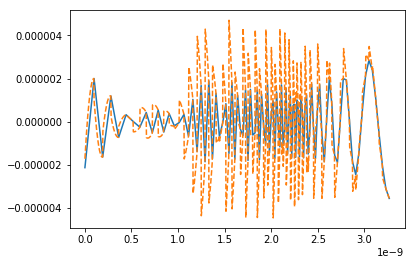

In [41]:
plt.plot(tau, x_test)
plt.plot(tau_int, x_int, '--')
plt.show()